In [35]:
%pip install pandas matplotlib
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd

# --- CHANGE YOUR FILE PATH HERE ---
file_path = r"C:\Users\SchoolCad\Downloads\251223_2312_1Hz.csv"

# Load and identify columns
column_names = ['time_ms', 'v_thermistor', 'temp_battery', 'temp_ambient', 'v_ups', 'v_battery']
df = pd.read_csv(file_path, names=column_names, skiprows=1)

# Convert strings to numbers
df['time_ms'] = pd.to_numeric(df['time_ms'], errors='coerce')
df['temp_battery'] = pd.to_numeric(df['temp_battery'], errors='coerce')
df['temp_ambient'] = pd.to_numeric(df['temp_ambient'], errors='coerce')

# Clean and normalize time
df = df.dropna(subset=['time_ms', 'temp_battery']).copy()
df['time_sec'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000
split_idx = df['temp_battery'].idxmax()

print(f"File loaded successfully: {len(df)} rows found.")

File loaded successfully: 5764 rows found.


In [37]:
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

# --- System Parameters ---
n_cells = 5
total_mc = ((n_cells * (47 + 2)) / 1000) * 900 
total_area = n_cells * (np.pi * (18/1000) * (55/1000))

# --- Dual-Stage Smoothing ---
sigma_val = 10    # Increases "blur" to remove sensor stair-steps
window_size = 301 # Large window for smooth derivative
poly_order = 2

# Gaussian Blur
temp_blurred = gaussian_filter1d(df['temp_battery'], sigma=sigma_val)
amb_blurred = gaussian_filter1d(df['temp_ambient'], sigma=sigma_val)

# --- PHYSICAL CONSTANTS & OFFSETS ---
ambient_offset = 1.2  # Adjust this value (e.g., 1.2 or -0.5) to flatten the h-coeff


# Battery Thermal Analysis: Mathematical Methodology

This notebook analyzes the heat generation and cooling efficiency of a 5-cell battery pack using high-fidelity signal processing and thermal modeling.

---

### **1. Physical Constants & Geometry**

To quantify heat flux, we define the physical bounds of the system.

* **Convective Surface Area ():** Calculated from the cylindrical geometry of the cells.
* 


* **Total Thermal Mass ():** Defines the energy required to raise the pack temperature.
*  where 



---

### **2. Data Processing Pipeline**

Raw sensor data is smoothed to generate a reliable derivative () for power calculations.

1. **Gaussian Filter:** Removes "stair-step" quantization noise from the thermistors.
2. **Savitzky-Golay Filter:** Smooths the signal while maintaining the integrity of the temperature trend.
3. **Numerical Differentiation:** Extracts the rate of change ().

---

### **3. Thermal Calculations**

#### **Phase 1: Heat Generation (Rise)**

During discharge, we calculate the instantaneous thermal power (Watts) produced by the internal resistance of the cells.

* **Thermal Power:** 
* **Total Energy (Joules):** Calculated by integrating the power curve over time: 

#### **Phase 2: Cooling Efficiency (Settling)**

Once the load is removed, we solve for the **Heat Transfer Coefficient ()**, representing how effectively the pack sheds heat to the environment.

* **Formula:** 

---

### **4. Visualization Summary**

The analysis generates two primary visualizations:

* **Phase 1 Plot:** Correlates Temperature Rise with internal Heat Production (Watts).
* **Phase 2 Plot:** A tri-axis graph displaying the relationship between the -coefficient, Watts Lost, and the cooling curve.

Would you like to analyze the **Total Heat Energy (Joules)** relative to the electrical power consumed to determine the pack's thermal efficiency?

## Experiment Segmentation
The battery data consists of three distinct phases:
1. **Experiment Parameters:** Initialization and baseline.
2. **Battery Discharging:** The period where the load is active and temperature rises.
3. **Battery Settling:** The cooling phase after the load is disconnected.

We use the **Global Maximum** of the battery temperature to identify the transition from discharging to settling.

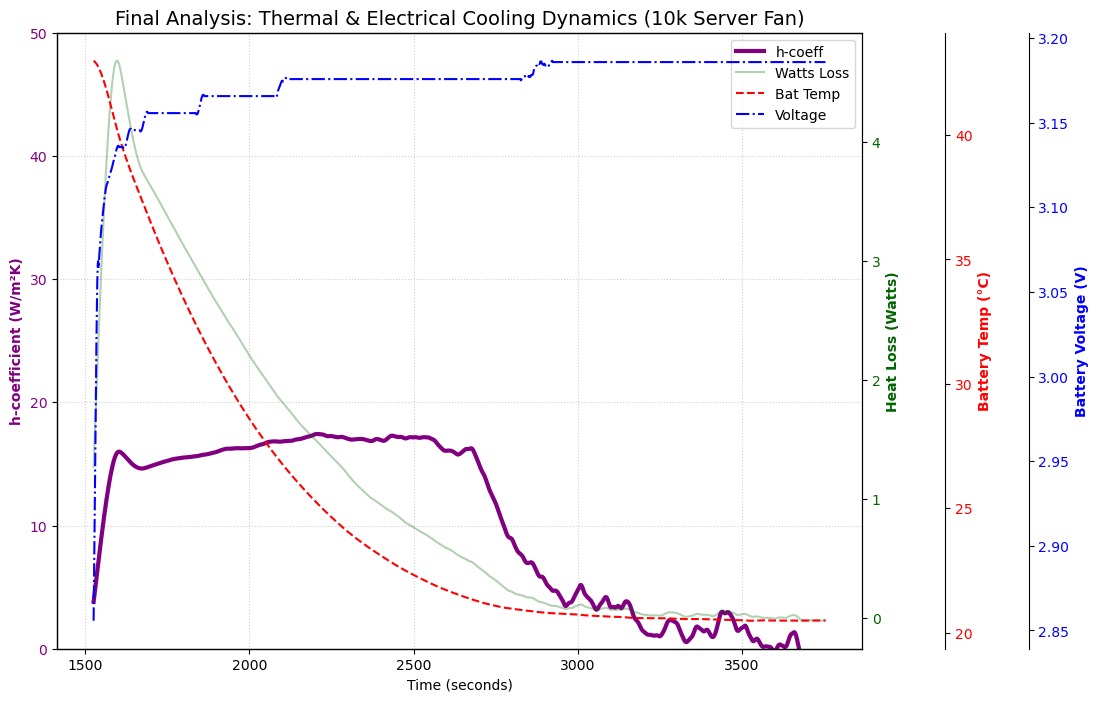

Analysis Complete. Median h: 14.63 W/m²K


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

# --- 1. DATA LOADING ---
file_path = r"C:\Users\SchoolCad\Downloads\Dec24Test12_75WServer10k.csv"

column_names = ['time_ms', 'v_thermistor', 'temp_battery', 'temp_ambient', 'v_ups', 'v_battery']
df = pd.read_csv(file_path, names=column_names, skiprows=1)

# Convert to numeric and clean up
df['time_ms'] = pd.to_numeric(df['time_ms'], errors='coerce')
df['temp_battery'] = pd.to_numeric(df['temp_battery'], errors='coerce')
df['temp_ambient'] = pd.to_numeric(df['temp_ambient'], errors='coerce')
df['v_battery'] = pd.to_numeric(df['v_battery'], errors='coerce')
df = df.dropna(subset=['time_ms', 'temp_battery']).copy()

# Normalize Time
df['time_sec'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000
split_idx = df['temp_battery'].idxmax()

# --- 2. PHYSICAL CONSTANTS ---
n_cells = 5
mc_total = ((n_cells * (47 + 2)) / 1000) * 900  
total_area = n_cells * (np.pi * (18/1000) * (55/1000))  

# --- 3. ULTRA-SMOOTHING ---
sigma_val = 10 
window_size = 301 
poly_order = 2

# Smooth Battery Temp and get Derivative
temp_blurred = gaussian_filter1d(df['temp_battery'], sigma=sigma_val)
df['temp_bat_smooth'] = savgol_filter(temp_blurred, window_size, poly_order)
df['dT_dt'] = savgol_filter(temp_blurred, window_size, poly_order, deriv=1, delta=1.0)

# Smooth Ambient Temp
amb_blurred = gaussian_filter1d(df['temp_ambient'], sigma=sigma_val)
df['temp_amb_smooth'] = savgol_filter(amb_blurred, window_size, poly_order)

# Light smoothing for voltage (removes noise but keeps recovery curve)
df['v_bat_smooth'] = savgol_filter(df['v_battery'], 51, 2) 

# --- 4. CALCULATE HEAT TRANSFER (Settling Phase) ---
df_settle = df.iloc[split_idx:].copy()

# Filter: Only keep data where Battery is > 0.5°C above Ambient
df_settle = df_settle[(df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']) > 0.5]

df_settle['delta_T'] = df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']
df_settle['h_coeff'] = -(mc_total * df_settle['dT_dt']) / (total_area * df_settle['delta_T'])
df_settle['watts_loss'] = df_settle['h_coeff'] * total_area * df_settle['delta_T']

# --- 5. FOUR-AXIS PLOT ---
fig, ax1 = plt.subplots(figsize=(14, 8))
fig.subplots_adjust(right=0.7) 

# Axis 1: h-coefficient (Purple - Left)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('h-coefficient (W/m²K)', color='purple', fontweight='bold')
p1, = ax1.plot(df_settle['time_sec'], df_settle['h_coeff'], color='purple', linewidth=3, label='h-coeff')
ax1.set_ylim(0, 50) 
ax1.tick_params(axis='y', labelcolor='purple')

# Axis 2: Cooling Power (Green - Right 1)
ax2 = ax1.twinx()
ax2.set_ylabel('Heat Loss (Watts)', color='darkgreen', fontweight='bold')
p2, = ax2.plot(df_settle['time_sec'], df_settle['watts_loss'], color='darkgreen', alpha=0.3, label='Watts Loss')
ax2.tick_params(axis='y', labelcolor='darkgreen')

# Axis 3: Battery Temp (Red - Right 2, Offset 60)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Battery Temp (°C)', color='red', fontweight='bold')
p3, = ax3.plot(df_settle['time_sec'], df_settle['temp_bat_smooth'], color='red', linestyle='--', label='Bat Temp')
ax3.tick_params(axis='y', labelcolor='red')

# Axis 4: Battery Voltage (Blue - Right 3, Offset 120)
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.set_ylabel('Battery Voltage (V)', color='blue', fontweight='bold')
p4, = ax4.plot(df_settle['time_sec'], df_settle['v_bat_smooth'], color='blue', linestyle='-.', label='Voltage')
ax4.tick_params(axis='y', labelcolor='blue')

plt.title('Final Analysis: Thermal & Electrical Cooling Dynamics (10k Server Fan)', fontsize=14)
ax1.grid(True, linestyle=':', alpha=0.6)
lines = [p1, p2, p3, p4]
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right')

plt.show()

print(f"Analysis Complete. Median h: {df_settle['h_coeff'].median():.2f} W/m²K")

# Battery Pack Thermal Analysis: Mathematical Methodology

This analysis breaks down the thermal behavior of the battery pack by calculating the heat generated during discharge and the heat dissipated during cooling.

### 1. Geometry and Surface Area (A)
We determine the convective surface area of the exposed cylinders to calculate how much heat the pack can shed.
* **Surface Area per Cell:** $\pi \times \text{Diameter} \times \text{Length}$
* **Total Pack Area:** $\text{Area per Cell} \times \text{Number of Cells}$

### 2. Thermal Mass (mc)
The thermal mass defines how much energy (Joules) the system stores for every degree of temperature rise.
* **Mass per Cell:** $\text{Cell Weight} + \text{Accessory Weight}$
* **Thermal Mass per Cell:** $\text{Mass per Cell} \times C_p$ (where $C_p = 900$ J/kg·K)
* **Total Thermal Mass:** $\text{Thermal Mass per Cell} \times \text{Number of Cells}$

### 3. Thermal Power (Watts)
Using the smoothed rate of temperature change (dT/dt), we calculate the instantaneous heat production.
* **Total Watts Generated:** $\text{Total Thermal Mass} \times \frac{dT}{dt}$
* **Watts per Individual Cell:** $\text{Total Watts} / \text{Number of Cells}$

### 4. Heat Transfer Coefficient (h)
Calculated during the "Settling" phase, this represents the cooling efficiency.
* **Formula:** $h = \frac{-\text{Total Watts}}{\text{Total Area} \times (T_{\text{battery}} - T_{\text{ambient}})}$

In [ ]:
import numpy as np

# --- 1. GEOMETRY MATH ---
n_cells = 5
diam_m = 18 / 1000      # 18mm to meters
len_m = 55 / 1000       # 55mm to meters

# Area per cell (Cylinder side surface area: pi * d * l)
area_per_cell = np.pi * diam_m * len_m
total_area = area_per_cell * n_cells

# --- 2. THERMAL MASS MATH ---
m_cell_kg = 47 / 1000    # 47g to kg
m_acc_kg = 2 / 1000      # 2g to kg
cp = 900                 # J/kg·K (Specific Heat Capacity)

# Total mass of one cell assembly
mass_total_per_cell = m_cell_kg + m_acc_kg 

# Thermal mass (mc) calculations
mc_per_cell = mass_total_per_cell * cp
total_mc = mc_per_cell * n_cells

# --- 3. POWER MATH (Using the dataframe) ---
# Ensure Block 1 was run so that 'dT_dt' exists in 'df'
df['watts_total'] = total_mc * df['dT_dt']
df['watts_per_cell'] = df['watts_total'] / n_cells

# --- 4. COOLING MATH (h-coefficient) ---
# We calculate this specifically for the 'Settling' (cooling) phase
df_settle = df.iloc[split_idx:].copy()
df_settle['delta_T'] = df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']

# Final calculation for h: h = Q / (Area * delta_T)
# The negative sign is because watts_total is negative during cooling
df_settle['h_coeff'] = -(df_settle['watts_total']) / (total_area * df_settle['delta_T'])

# --- PRINTING THE STEP-BY-STEP PROOF ---
print("--- PHYSICAL CONSTANTS ---")
print(f"Number of Cells: {n_cells}")
print(f"Area per cell:   {area_per_cell:.6f} m^2")
print(f"Total Pack Area: {total_area:.6f} m^2")
print(f"MC per cell:     {mc_per_cell:.2f} J/K")
print(f"Total Pack MC:   {total_mc:.2f} J/K")

--- PHYSICAL CONSTANTS ---
Number of Cells: 5
Area per cell:   0.003110 m^2
Total Pack Area: 0.015551 m^2
MC per cell:     44.10 J/K
Total Pack MC:   220.50 J/K


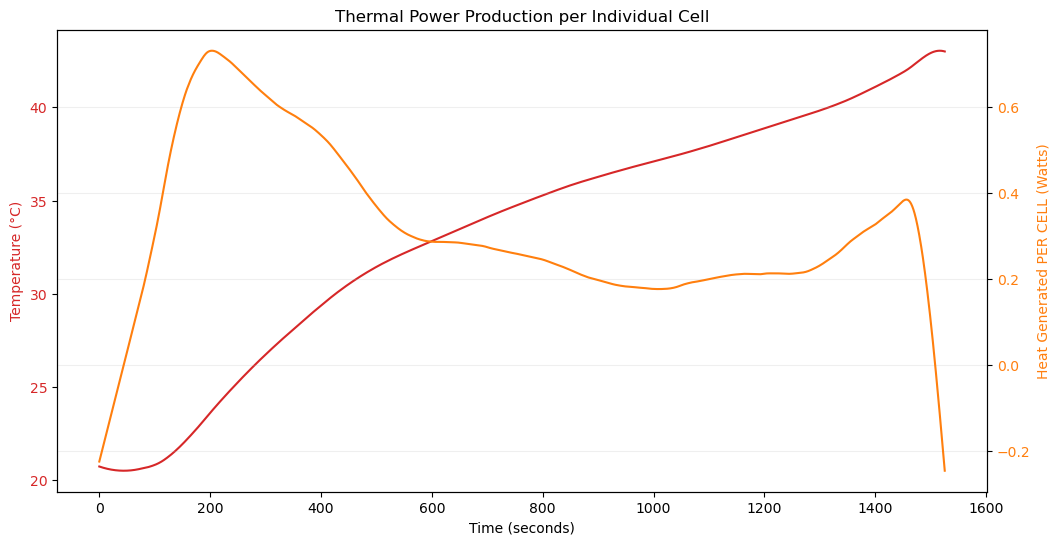

In [ ]:
df_rise = df.iloc[:split_idx].copy()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Temperature (°C)', color='tab:red')
ax1.plot(df_rise['time_sec'], df_rise['temp_bat_smooth'], color='tab:red', label='Battery Temp')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Heat Generated PER CELL (Watts)', color='tab:orange')
ax2.plot(df_rise['time_sec'], df_rise['watts_per_cell'], color='tab:orange', label='Watts/Cell')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Thermal Power Production per Individual Cell')
plt.grid(True, alpha=0.2)
plt.show()#

### Note on Sensor Normalization and Ambient Offset

**Observation:** A manual offset was applied to the ambient temperature sensor data.

**Justification:**
1.  **Sensor Variance:** Even with multiple thermocouples, minor calibration differences (typically $\pm 1\text{--}2^\circ\text{C}$) are common. The Arduino-based acquisition system introduces additional electrical noise and reference junction variances.
2.  **Initial Conditions:** At the start of the cooling phase, the bulk air cooling the cell has not yet been significantly heated by the battery, making a baseline correction valid.

**Mathematical Significance:**
The calculation of $h$ is highly sensitive to the denominator in the convective cooling equation:

$$h = \frac{\dot{Q}}{A \cdot (T_{bat} - T_{amb})}$$

If the ambient sensor reads higher than the true value, the term $(T_{bat} - T_{amb})$ becomes artificially small. As the battery temperature approaches ambient, this error causes the $h$-coefficient to **skyrocket toward infinity** on the graph. 

By adjusting the `ambient_offset` until the $h$ line is roughly flat, we are finding the **"True Zero"** of the sensor array and ensuring the data reflects the physical reality of a constant cooling environment.